In [1]:
import ee
import geemap
import sys,os
sys.path.append(r'C:\09_Code\Gis_Script\GEE_Func')
from S1_distor_dedicated import load_S1collection,S1_CalDistor,DEM_caculator
from S2_filter import merge_s2_collection
from GEE_DataIOTrans import BandTrans,DataTrans,DataIO
from GEE_CorreterAndFilters import S1Corrector
import math
from functools import partial
from tqdm import tqdm 

# 重载函数
# import importlib
# importlib.reload(S1_distor_dedicated)

geemap.set_proxy(port=10809)
# ee.Authenticate()
ee.Initialize()

torch or torchvision do not import
GEE_DataIOTrans not support gdal
rasterio not import


In [2]:
# 获取S1 、 DEM
AOI =  ee.Geometry.Polygon([[[93.15172089782506, 30.60689894788499],
   [93.20966268713462, 30.60689894788499],
   [93.20966268713462, 30.63625137380944],
   [93.15172089782506, 30.63625137380944],
   [93.15172089782506, 30.60689894788499]]])

year = '2019'
START_DATE  = ee.Date(year + '-01-01')
END_DATE   = ee.Date(year + '-12-30')
TIME_LEN   = END_DATE.difference(START_DATE, 'days').abs()
MIDDLE_DATE = START_DATE.advance(TIME_LEN.divide(ee.Number(2)).int(),'days')
Origin_scale = 10
Prj_scale = 30


s1_ascending, s1_descending = load_S1collection(AOI,START_DATE,END_DATE,MIDDLE_DATE,FilterSize=30)
DEMSRTM = ee.Image('USGS/SRTMGL1_003')
DEM_prj = DEMSRTM.projection()

S1_image = s1_ascending
DEM = DEMSRTM
Projection = S1_image.select(0).projection()
Mask = S1_image.select(0).mask()

# 获取辅助线
azimuthEdge, rotationFromNorth, startpoint, endpoint, coordinates_dict  = S1Corrector.getS1Corners(s1_ascending, AOI,'ASCENDING')

Heading = azimuthEdge.get('azimuth')
s1_azimuth_across = ee.Number(Heading).subtract(90.0) # 距离向
Auxiliarylines = ee.Geometry.LineString([startpoint, endpoint])

Eq_pixels = DataTrans.Eq_pixels

BandTrans.delBands(S1_image, ['VH', 'VV'])
Cal_image = (Eq_pixels(BandTrans.delBands(S1_image, 'VV','VH').resample('bicubic')).rename('angle')
                      .addBands(ee.Image.pixelCoordinates(Projection))
                      .addBands(DEM.select('elevation'))
                      .addBands(ee.Image.pixelLonLat())
                      .updateMask(Mask)
                      .reproject(crs=Projection, scale=Prj_scale)
                      .clip(AOI))
Templist_A = S1_CalDistor.AuxiliaryLine2Point(Cal_image, s1_azimuth_across, coordinates_dict, Auxiliarylines, Origin_scale)

Without Filter


In [3]:
import numpy as np
from scipy.optimize import least_squares
from tqdm import tqdm

# 面转线-->获取4、9邻域-->计算代求点高程

def Line2Points(feature,region,scale=30):
    # 从Feature中提取线几何对象
    line_geometry = ee.Feature(feature).geometry().intersection(region)
    
    # 获取线的所有坐标点
    coordinates = line_geometry.coordinates()
    start_point = ee.List(coordinates.get(0)) # 起点坐标
    end_point = ee.List(coordinates.get(-1))  # 终点坐标
    
    # 获取线段的总长度
    length = line_geometry.length()

    # 计算插入点的数量
    num_points = length.divide(scale).subtract(1).floor()

    # 计算每个间隔点的坐标
    def interpolate(i):
        i = ee.Number(i)
        fraction = i.divide(num_points)
        interpolated_lon = ee.Number(start_point.get(0)).add(
            ee.Number(end_point.get(0)).subtract(ee.Number(start_point.get(0))).multiply(fraction))
        interpolated_lat = ee.Number(start_point.get(1)).add(
            ee.Number(end_point.get(1)).subtract(ee.Number(start_point.get(1))).multiply(fraction))
        return ee.Feature(ee.Geometry.Point([interpolated_lon, interpolated_lat]))

    # 使用条件表达式过滤长度为0的线段
    filtered_points = ee.FeatureCollection(ee.Algorithms.If(num_points.gt(0), 
                                                            ee.FeatureCollection(ee.List.sequence(1, num_points).map(interpolate)),
                                                            ee.FeatureCollection([])))

    return filtered_points

def map_function(item,len=3):
    '''该函数len=3起步判断，由于len=2的时候会将单点判定为正确，故存在误差
     为了节省计算量，未对此处进行修改'''
    item_list = ee.List(item)
    return ee.Algorithms.If(item_list.size().gte(len), item_list, None)

def get_neighborhood_info(point,image,scale=30,neighborhood_type='4'):
    
    point = ee.Geometry.Point(point)
    buffer_region = point.buffer(30)

    # 生成矩形区域
    region = buffer_region.bounds()
    # 获取矩形的坐标
    coords  = ee.List(region.coordinates().get(0))

    # 提取四个角点坐标
    corner1 = ee.Geometry.Point(ee.List(coords.get(0)))
    corner2 = ee.Geometry.Point(ee.List(coords.get(1)))
    corner3 = ee.Geometry.Point(ee.List(coords.get(2)))
    corner4 = ee.Geometry.Point(ee.List(coords.get(3)))
    
    if neighborhood_type=='4':
        # 创建包含所有点的MultiPoint几何对象
        region_coord = ee.Geometry.MultiPoint([
                                                corner1.coordinates(), corner2.coordinates(), 
                                                corner3.coordinates(), corner4.coordinates()])
    
    elif neighborhood_type=='9': 
        # 创建线段并计算边的中心点
        edge_center1 = ee.Geometry.LineString([corner1.coordinates(), corner2.coordinates()]).centroid()
        edge_center2 = ee.Geometry.LineString([corner2.coordinates(), corner3.coordinates()]).centroid()
        edge_center3 = ee.Geometry.LineString([corner3.coordinates(), corner4.coordinates()]).centroid()
        edge_center4 = ee.Geometry.LineString([corner4.coordinates(), corner1.coordinates()]).centroid()

        # 创建包含所有点的MultiPoint几何对象
        region_coord = ee.Geometry.MultiPoint([
                        corner1.coordinates(), corner2.coordinates(), 
                        corner3.coordinates(), corner4.coordinates(),
                        edge_center1.coordinates(), edge_center2.coordinates(), 
                        edge_center3.coordinates(), edge_center4.coordinates(),
                        point.coordinates()])
    else:
        print('neighborhood_type should be "4" or "9"')

    # 使用MultiPoint几何对象作为geometry参数
    result = image.reduceRegion(
        reducer=ee.Reducer.toList(),  # 转换为列表
        geometry=region_coord,
        scale=scale,
        maxPixels=1e9)

    # 在结果中添加点坐标
    result = result.set('point_coordinates', point.coordinates())
    
    return result 

def weighted_avg_func(neighbor):
    # 使用ee.Number转换index，因为原始的index是ee.ComputedObject
    neighbors_info = ee.Dictionary(neighbor)

    # 将邻域点信息转换为ee.Array
    lon_coords = ee.Array(neighbors_info.get('longitude'))
    lat_coords = ee.Array(neighbors_info.get('latitude'))
    elevations = ee.Array(neighbors_info.get('elevation'))
    x_ = ee.Array(neighbors_info.get('x'))
    y_ = ee.Array(neighbors_info.get('y'))
    angles = ee.Array(neighbors_info.get('angle'))
    point_coords  = ee.List(neighbors_info.get('point_coordinates'))
    
    # 计算距离和权重
    point1_x = ee.Number(point_coords.get(0))
    point1_y = ee.Number(point_coords.get(1))
    distances = lon_coords.subtract(point1_x).pow(2).add(lat_coords.subtract(point1_y).pow(2)).sqrt()
    weights = distances.pow(-1)
    sum_weights = weights.reduce(ee.Reducer.sum(), [0])

    # 计算加权平均高程
    weighted_elevations = elevations.multiply(weights)
    weighted_avg_elevation = weighted_elevations.reduce(ee.Reducer.sum(), [0]).divide(sum_weights).get([0])

    # 计算平均角度
    weighted_angles = angles.multiply(weights)
    weighted_avg_angles = weighted_angles.reduce(ee.Reducer.sum(), [0]).divide(sum_weights).get([0])
    
    # 计算平均x
    weighted_X = x_.multiply(weights)
    weighted_avg_X = weighted_X.reduce(ee.Reducer.sum(), [0]).divide(sum_weights).get([0])
    
    # 计算平均y
    weighted_Y = y_.multiply(weights)
    weighted_avg_Y = weighted_Y.reduce(ee.Reducer.sum(), [0]).divide(sum_weights).get([0])

    return ee.Dictionary({'elevation': weighted_avg_elevation,'angle':weighted_avg_angles,
                          'x':weighted_avg_X,'y':weighted_avg_Y})

def avg_func(neighbor):
    neighbors_info = ee.Dictionary(neighbor)
    elevations = ee.Array(neighbors_info.get('elevation'))
    angles = ee.Array(neighbors_info.get('angle'))
    x_ = ee.Array(neighbors_info.get('x'))
    y_ = ee.Array(neighbors_info.get('y'))
    return ee.Dictionary({'elevation':elevations.reduce(ee.Reducer.mean(),[0]).get([0]) ,
                           'angle':angles.reduce(ee.Reducer.mean(),[0]).get([0]),
                           'x':x_.reduce(ee.Reducer.mean(),[0]).get([0]),
                           'y':y_.reduce(ee.Reducer.mean(),[0]).get([0])})

def Volum9_func(neighbors_info):
    
    # 修改方程函数以匹配新的模型
    def equation(params, x, y):
        a, b, c, d, e, f = params
        return a*x**2 + b*y**2 + c*x*y + d*x + e*y + f

    # 修改残差函数，去除z作为变量
    def residuals(params, x, y, z_true):
        z_pred = equation(params, x, y)
        return z_pred - z_true
    
    # 根据求得的参数和给定点的经纬度计算高程
    def calculate_z(params, x, y):
        # 根据新模型参数更新，只有6个参数
        a, b, c, d, e, f = params
        # 更新方程以反映新的模型形式
        z_pred = a*x**2 + b*y**2 + c*x*y + d*x + e*y + f
        return z_pred
    

    lon = np.array(neighbors_info['longitude'])
    lat = np.array(neighbors_info['latitude'])
    elevation = np.array(neighbors_info['elevation'])
    angles = np.array(neighbors_info['angle'])
    x_ = np.array(neighbors_info['x'])
    y_ = np.array(neighbors_info['y'])
    lon_pre, lat_pre = np.array(neighbors_info['point_coordinates'])

    # 初始参数猜测
    initial_guess = np.zeros(6)

    # 使用最小二乘法求得的参数,预测高程
    result0 = least_squares(residuals, initial_guess, args=(lon, lat, elevation))
    params0 = result0.x  
    z_pred = calculate_z(params0, lon_pre, lat_pre)

    # 使用最小二乘法求得的参数,预测angle
    result1 = least_squares(residuals, initial_guess, args=(lon, lat, angles))
    params1 = result1.x  
    angle_pred = calculate_z(params1, lon_pre, lat_pre)
    
    # 使用最小二乘法求得的参数,预测x
    result2 = least_squares(residuals, initial_guess, args=(lon, lat, x_))
    params2 = result2.x  
    x_pred = calculate_z(params2, lon_pre, lat_pre)
    
    # 使用最小二乘法求得的参数,预测y
    result3 = least_squares(residuals, initial_guess, args=(lon, lat, y_))
    params3 = result3.x  
    y_pred = calculate_z(params3, lon_pre, lat_pre)
    
    
    return {'elevation':z_pred,'angle':angle_pred,
            'x':x_pred,'y':y_pred}

def Flat4_func(neighbors_info):

    lon = neighbors_info['longitude']
    lat = neighbors_info['latitude']
    elevation = neighbors_info['elevation']
    angles = np.array(neighbors_info['angle'])
    x_ = np.array(neighbors_info['x'])
    y_ = np.array(neighbors_info['y'])
    lon_pred, lat_pred = np.array(neighbors_info['point_coordinates'])
    
    A = np.vstack([lon, lat, np.ones(len(lon))]).T  # 构建矩阵A

    b = elevation  # 高程向量b
    # 使用最小二乘法解方程Ax = b
    x, residuals, rank, s = np.linalg.lstsq(A, b, rcond=None)
    # x包含拟合参数a, b, c（注意这里不再是1/c）
    a, b, c = x
    z_pred = a * lon_pred + b * lat_pred + c

    b = angles
    x, residuals, rank, s = np.linalg.lstsq(A, b, rcond=None)
    a, b, c = x
    angle_pred = a * lon_pred + b * lat_pred + c
    
    b = x_
    x, residuals, rank, s = np.linalg.lstsq(A, b, rcond=None)
    a, b, c = x
    x_pred = a * lon_pred + b * lat_pred + c
    
    b = y_
    x, residuals, rank, s = np.linalg.lstsq(A, b, rcond=None)
    a, b, c = x
    y_pred = a * lon_pred + b * lat_pred + c

    return {'elevation':z_pred,'angle':angle_pred,'x':x_pred,'y':y_pred}

def apply_map_to_list(input_list, func): return input_list.map(func)

def apply_map_to_list_local(input_list, func): return map(func,input_list)

Len_Templist_A =  Templist_A.size().getInfo()
pbar = tqdm(range(Len_Templist_A),ncols=80)
Neighbors = '4' # '9'

# 需要注意'Area_elavation','Volum_elavation'涉及数学拟合，GEE-->Python环境
Elvevation_model = 'weighted_avg_elevation' #'weighted_avg_elevation' , 'avg_elevation', 'Area_elavation','Volum_elavation'

All_PointLine = [] 
for i in pbar:
    points = Line2Points(Templist_A.get(i),region=AOI,scale=Prj_scale)  
    points = points.geometry().coordinates()
    All_PointLine.append(points)
    
EE_PointLine = ee.List(All_PointLine[110:111])

# 使用 map() 方法应用映射函数
EE_PointLine = EE_PointLine.map(partial(map_function,len=3)).removeAll([None])

cal_neighbors = apply_map_to_list(EE_PointLine, 
                               lambda x: ee.List(x).map(partial(get_neighborhood_info,image=Cal_image,
                                                                scale=Prj_scale,neighborhood_type=Neighbors)))

##------------------------------------需要添加过滤cal_neighbors数据的方法
##  将个数不满足Neighbors的条目去除


if Elvevation_model == 'weighted_avg_elevation':
    Points_weighted_avg = apply_map_to_list(
                                        cal_neighbors,      
                                        lambda x: ee.List(x).map(weighted_avg_func))
    
elif Elvevation_model == 'avg_elevation':
    Points_avg = apply_map_to_list(
                                        cal_neighbors,
                                        lambda x: ee.List(x).map(avg_func))
    
elif (Elvevation_model == 'Area_elavation') or (Elvevation_model == 'Volum_elavation'):

    neighbors_info = cal_neighbors.getInfo() # 非常大
    if Elvevation_model == 'Area_elavation':
        Points_area4 = list(apply_map_to_list_local(neighbors_info,lambda x: list(map(Flat4_func,x))))
    elif Elvevation_model == 'Volum_elavation':
        Points_volum9 = list(apply_map_to_list_local(neighbors_info,lambda x: list(map(Volum9_func,x))))

100%|█████████████████████████████████████████| 557/557 [00:06<00:00, 89.47it/s]


In [16]:
A= ee.List(points_elevations_neighborhood.get(0)).map(lambda x: ee.Dictionary(x).get('elevation')).getInfo()
# 将数据转换为 JSON 格式并保存到文件中
with open('A.json', 'w') as json_file:
    json.dump(A, json_file, indent=4)

In [49]:
# 创建一个包含字典的 ee.List
list_of_dicts = ee.List(
 [{'angle': 66.81194805106554, 'elevation': 4682.312272557328},
 {'angle': 58.68166331454356, 'elevation': 4692.902242634673},
 {'angle': 72.64161746553282, 'elevation': 4697.801418249133},
 {'angle': 74.41960159366695, 'elevation': 4706.258873798326},
 {'angle': 74.53567491420888, 'elevation': 4714.111177784898},
 {'angle': 73.42794799855496, 'elevation': 4720.8847888424525},
 {'angle': 74.00165447852532, 'elevation': 4715.670241493767},
 {'angle': 75.40336366035261, 'elevation': 4721.615461878329},
 {'angle': 75.56375402678539, 'elevation': 4725.8872139593395},
 {'angle': 74.84111860979337, 'elevation': 4730.587222984088},
 {'angle': 75.04654545491525, 'elevation': 4723.031961775998},
 {'angle': 76.09037596759183, 'elevation': 4726.257047935649},
 {'angle': 76.28850795501054, 'elevation': 4730.9198299179425},
 {'angle': 75.82447401573388, 'elevation': 4735.393680590829},
 {'angle': 75.74891849968948, 'elevation': 4723.7096806259015},
 {'angle': 76.52227140955289, 'elevation': 4724.9506532323085},
 {'angle': 76.61767061022337, 'elevation': 4724.155707513975},
 {'angle': 76.1908059919579, 'elevation': 4723.6889702289245},
 {'angle': 75.98968146369278, 'elevation': 4711.696490662983},
 {'angle': 76.56035621288748, 'elevation': 4712.089371596387},
 {'angle': 76.62914006740652, 'elevation': 4711.832911695272},
 {'angle': 76.23227814727178, 'elevation': 4712.332531788623},
 {'angle': 75.99012454112277, 'elevation': 4705.315003052202},
 {'angle': 76.43202083122266, 'elevation': 4702.662948019452},
 {'angle': 76.44701947602115, 'elevation': 4701.476487109313}])
# 提取所有的 'elevation' 值并转换为 ee.List
elevations = list_of_dicts.map(lambda x: ee.Dictionary(x).get('elevation'))

import pandas as pd
# 读取CSV文件中的散点数据
pdcsv = pd.read_json(r"C:\09_Code\Gis_Script\04_修正几何畸变矫正与冰湖提取\A.json")
# 提取散点数据
x_fit = pdcsv.index.values.tolist()
y_fit = pdcsv.values.flatten().tolist()
elevations = ee.List(y_fit)

# 定义一个函数来计算一阶导数，使导数的数量与原数据相同
def compute_derivative_same_length(elev_list):
    def diff_helper(index):
        index = ee.Number(index)  # 包装 index 为 ee.Number
        current = ee.Number(elev_list.get(index))
        next_ = ee.Number(elev_list.get(index.add(1)))
        prev = ee.Number(elev_list.get(index.subtract(1)))
        return ((next_.subtract(current))
                .add(current.subtract(prev))).divide(2)
    
    # 对 elevation 列表进行微分，得到一阶导数
    first_derivative = ee.List.sequence(1, elev_list.size().subtract(2)).map(diff_helper)
    
    # 使用前向差分和后向差分来计算序列的第一个和最后一个点的导数
    first_point_derivative = ee.Number(elev_list.get(1)).subtract(ee.Number(elev_list.get(0)))
    last_point_derivative = ee.Number(elev_list.get(-1)).subtract(ee.Number(elev_list.get(-2)))
    
    # 将导数序列的第一个和最后一个点的导数添加到导数序列中
    derivative_same_length = ee.List([first_point_derivative]).cat(first_derivative).add(last_point_derivative)
    
    return derivative_same_length

# 计算曲率
def compute_curvature(first_deriv, second_deriv):
    def curvature_helper(index):
        y_prime = ee.Number(first_deriv.get(index))
        y_double_prime = ee.Number(second_deriv.get(index))
        return ee.Number.abs(y_double_prime).divide(y_prime.pow(2).add(1).pow(1.5))
    return ee.List.sequence(0, first_deriv.size().subtract(1)).map(curvature_helper)

# 计算曲率局部极大值的索引
def find_local_maxima_indices(curvature_list):
    # 创建一个包含索引和值的新列表
    indexed_list = curvature_list.zip(ee.List.sequence(0, curvature_list.size().subtract(1)))
    
    def local_maxima_helper(element):
        element = ee.List(element)
        current = ee.Number(element.get(0))
        index = ee.Number(element.get(1))
        prev = ee.Number(curvature_list.get(index.subtract(1)))
        next_ = ee.Number(curvature_list.get(index.add(1)))
        
        # 处理边界情况
        prev = ee.Algorithms.If(index.eq(0), current, prev)
        next_ = ee.Algorithms.If(index.eq(curvature_list.size().subtract(1)), current, next_)
        
        is_local_maxima = current.gt(prev).And(current.gt(next_))
        return ee.Algorithms.If(is_local_maxima, index, None)
    
    maxima_indices = indexed_list.map(local_maxima_helper).removeAll([None])
    return maxima_indices

def filter_indices(combined_list):
    def filter_helper(element):
        index = combined_list.indexOf(element)
        derivs = ee.List(element)
        condition = ee.Number(derivs.get(0)).gte(0) \
                    .And(ee.Number(derivs.get(1)).lte(0)) \
                    .And(ee.Number(derivs.get(2)).gte(0))
        return ee.Algorithms.If(condition, index, None)
    
    indices = combined_list.map(filter_helper)
    # 移除None值
    filtered_indices = indices.removeAll([None])
    return filtered_indices

# 计算n阶导数\曲率
first_derivative = compute_derivative_same_length(elevations)
second_derivative = compute_derivative_same_length(first_derivative)
third_derivative = compute_derivative_same_length(second_derivative)
curvature = compute_curvature(first_derivative, second_derivative)
# 将三个导数列表组合起来

combined_derivatives = first_derivative\
                        .zip(second_derivative)\
                        .zip(third_derivative)\
                        .map(lambda x: ee.List(x).flatten())
                        
filtered_derivatives_indices = filter_indices(combined_derivatives)
curvature_local_maxima_indices = find_local_maxima_indices(curvature)
elevations_local_maxima_indices = find_local_maxima_indices(elevations)
# 求交集
intersection_indices = filtered_derivatives_indices.filter(ee.Filter.inList('item', curvature_local_maxima_indices))
# 求并集
union_indices = (intersection_indices.cat(elevations_local_maxima_indices)).distinct()

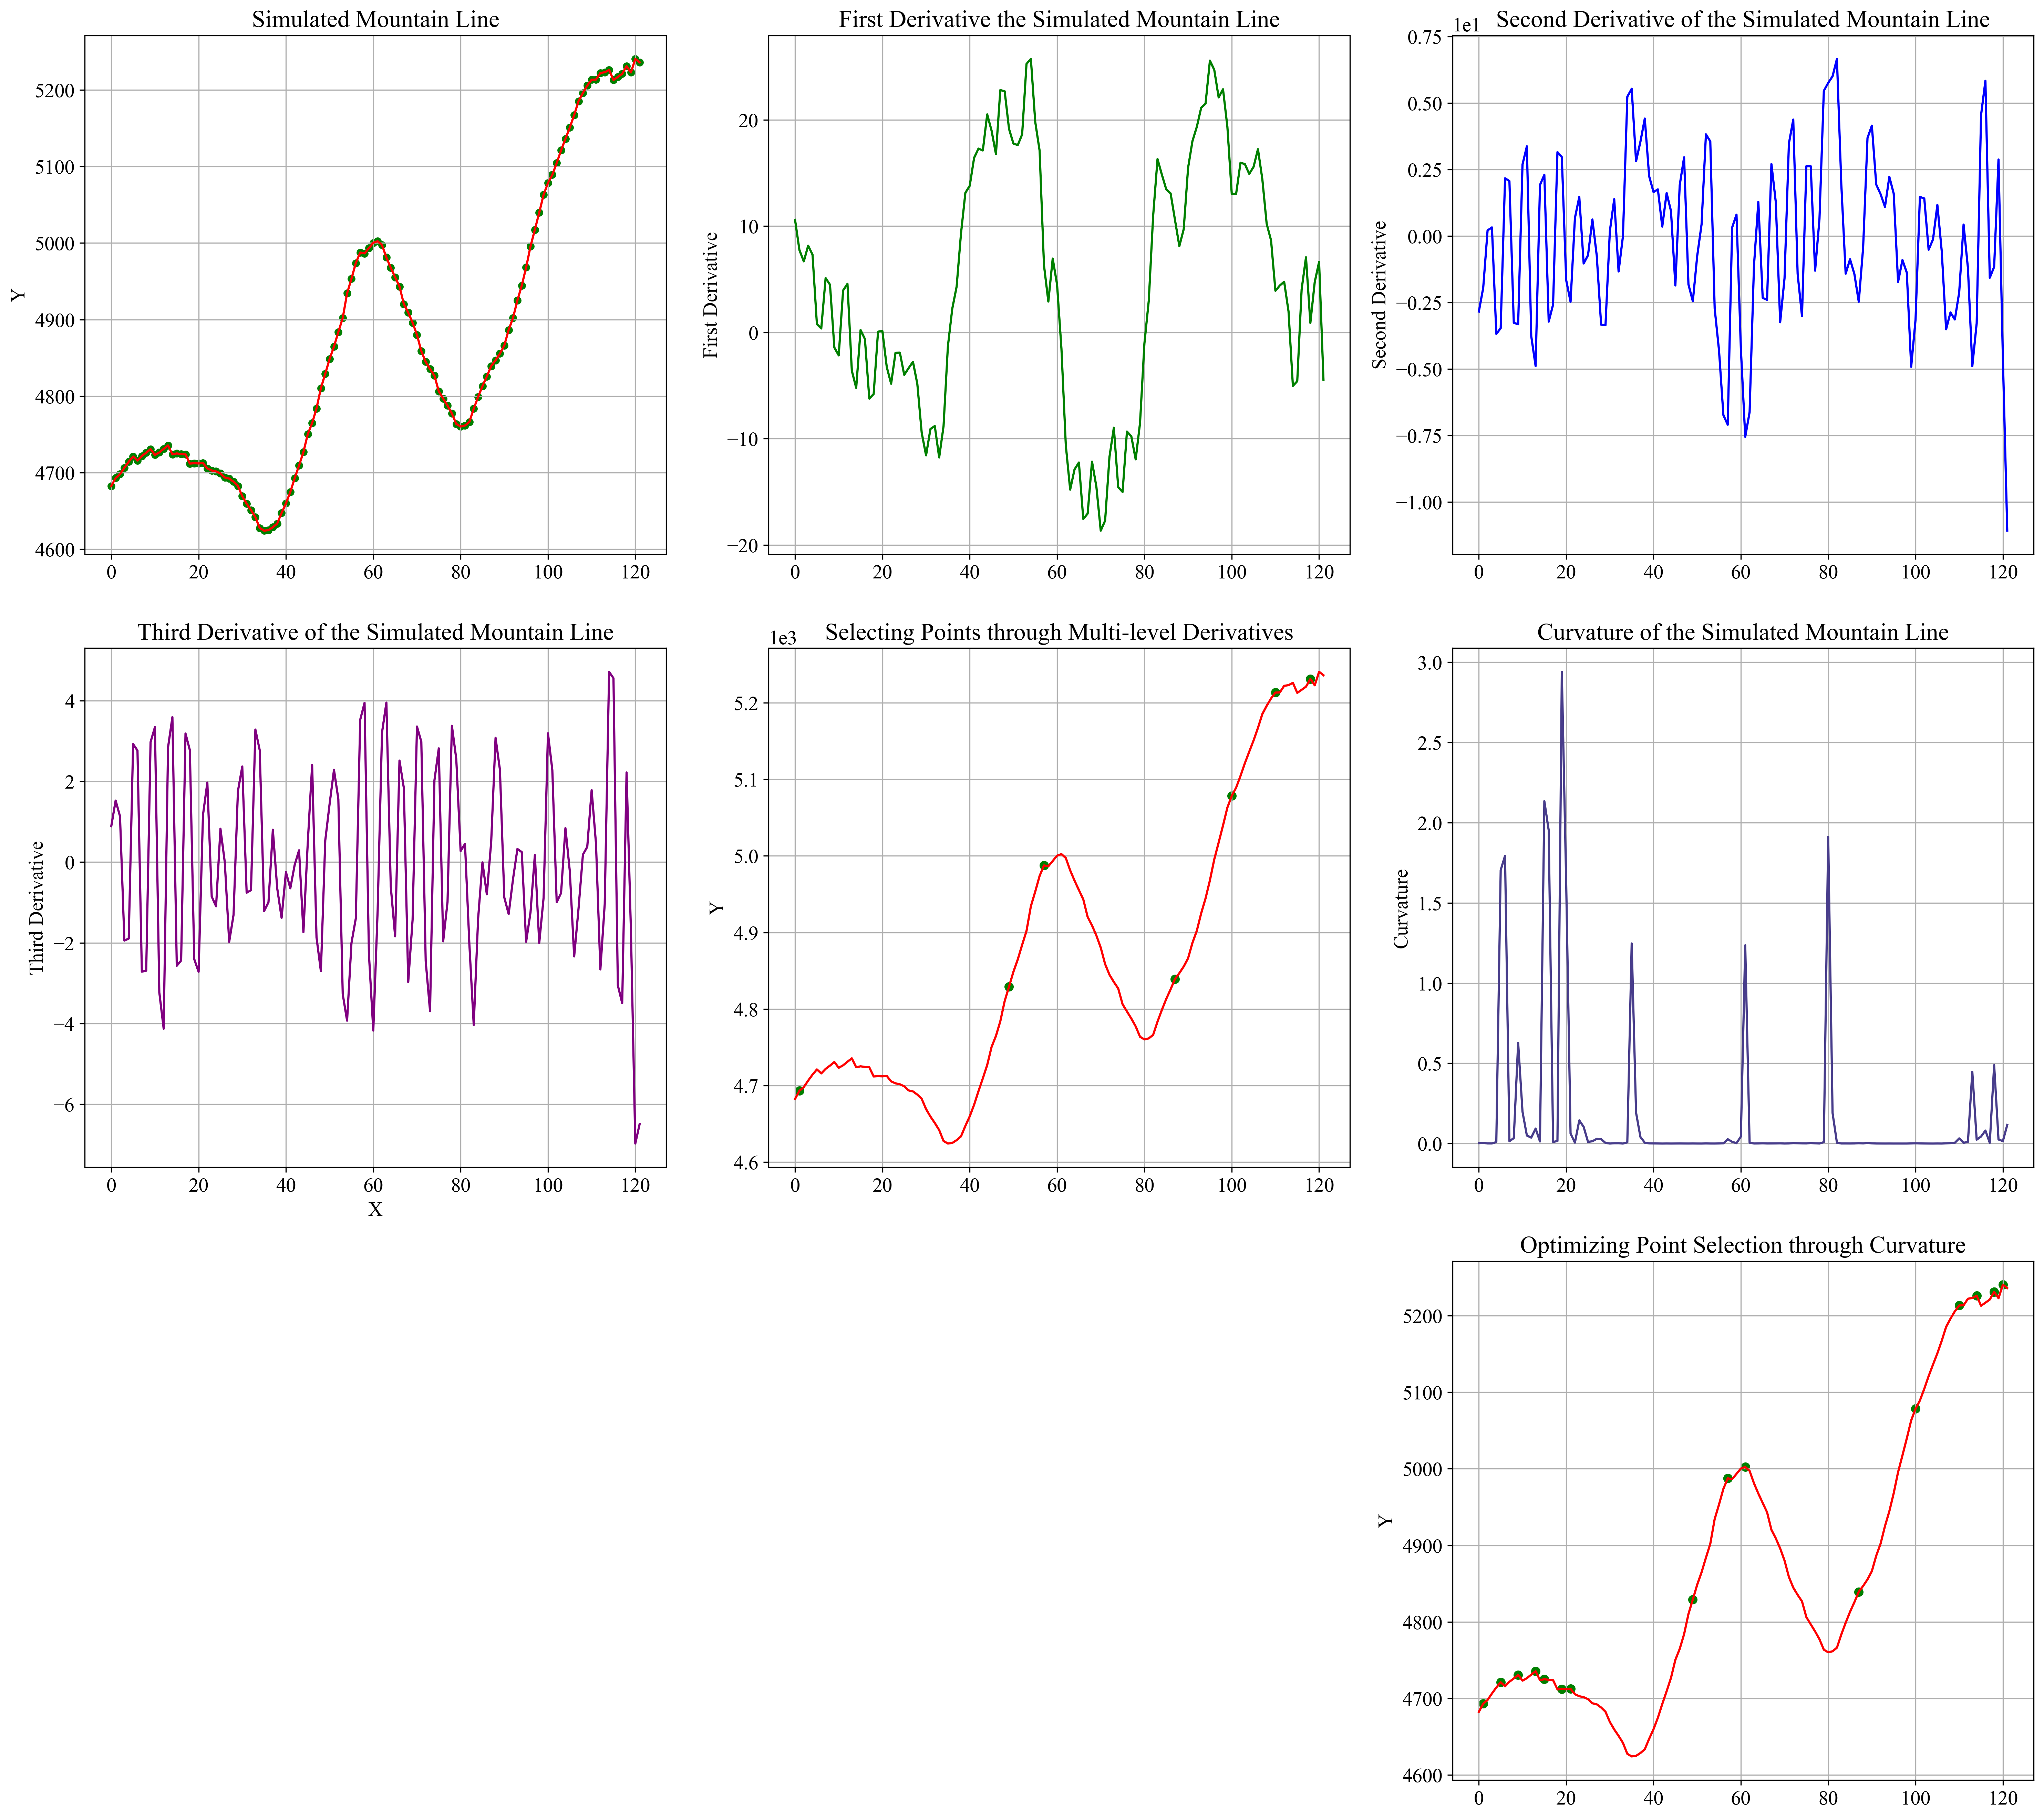

In [60]:
import matplotlib.pyplot as plt
x_fit = np.array(x_fit)
y_fit = np.array(y_fit)
plt.figure(figsize=(20, 18))
plt.rcParams.update({'font.family': 'Times New Roman', 'font.size': 14, 'figure.dpi': 300})

plt.subplot(3, 3, 1)
plt.plot(x_fit, y_fit, color='red', linewidth=1.5)
plt.scatter(x_fit, y_fit, color='green', marker='o', s=20)
plt.ylabel('Y')
plt.title('Simulated Mountain Line')
plt.grid(True)

plt.subplot(3, 3, 2)
plt.plot(x_fit, first_derivative.getInfo(), color='green')
plt.ylabel('First Derivative')
plt.title('First Derivative the Simulated Mountain Line')
plt.grid(True)

plt.subplot(3, 3, 3)
plt.plot(x_fit, second_derivative.getInfo(), color='blue')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))  # 使用科学计数法表示y轴标注  
plt.ylabel('Second Derivative')
plt.title('Second Derivative of the Simulated Mountain Line')
plt.grid(True)

plt.subplot(3, 3, 4)
plt.plot(x_fit, third_derivative.getInfo(), color='purple')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))  # 使用科学计数法表示y轴标注
plt.xlabel('X')
plt.ylabel('Third Derivative')
plt.title('Third Derivative of the Simulated Mountain Line')
plt.grid(True)

plt.subplot(3, 3, 5)
plt.plot(x_fit, y_fit, color='red', linewidth=1.5)  # 先绘制曲线
plt.scatter(x_fit[intersection_indices.getInfo()], y_fit[intersection_indices.getInfo()], color='green', marker='o', s=30)  # 绘制转折点
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))  # 使用科学计数法表示y轴标注
plt.ylabel('Y')
plt.title('Selecting Points through Multi-level Derivatives')
plt.grid(True)

plt.subplot(3, 3, 6)
plt.plot(x_fit, curvature.getInfo(), color='darkslateblue', label='Curvature')  # 将曲线颜色改为青色
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))  # 使用科学计数法表示y轴标注
plt.ylabel('Curvature')
plt.title('Curvature of the Simulated Mountain Line')
plt.grid(True)

plt.subplot(3, 3, 9)
plt.plot(x_fit, y_fit, color='red')
plt.scatter(x_fit[union_indices.getInfo()], y_fit[union_indices.getInfo()], color='green', marker='o', s=30)
plt.ylabel('Y')
plt.title('Optimizing Point Selection through Curvature')
plt.grid(True)

plt.tight_layout()
plt.show()

In [59]:
np.array(x_fit)[[1,2]]

array([1, 2])

[1, 49, 57, 87, 100, 110, 118]

In [173]:
from collections import OrderedDict

# 读取CSV文件中的散点数据
pdcsv = pd.read_json(r"D:\09_Code\Gis_Script\04_修正几何畸变矫正与冰湖提取\A.json")

# 提取散点数据
x_data = pdcsv.index.values.tolist()
y_data = pdcsv.values.flatten().tolist()

# 使用OrderedDict构建有序字典
ordered_dict = OrderedDict(zip(x_data, y_data))

print(ordered_dict)

OrderedDict([(0, 4682.312272557328), (1, 4692.902242634673), (2, 4697.801418249133), (3, 4706.258873798326), (4, 4714.111177784898), (5, 4720.8847888424525), (6, 4715.670241493767), (7, 4721.615461878329), (8, 4725.8872139593395), (9, 4730.587222984088), (10, 4723.031961775998), (11, 4726.257047935649), (12, 4730.9198299179425), (13, 4735.393680590829), (14, 4723.7096806259015), (15, 4724.9506532323085), (16, 4724.155707513975), (17, 4723.6889702289245), (18, 4711.696490662983), (19, 4712.089371596387), (20, 4711.832911695272), (21, 4712.332531788623), (22, 4705.315003052202), (23, 4702.662948019452), (24, 4701.476487109313), (25, 4698.848953753407), (26, 4693.485121369029), (27, 4692.120611793518), (28, 4687.956291855047), (29, 4682.420928290467), (30, 4669.067835059738), (31, 4659.279534537731), (32, 4650.888273437276), (33, 4641.659890364669), (34, 4627.350279229669), (35, 4623.989949394491), (36, 4624.743201753795), (37, 4628.442218292549), (38, 4633.355672026659), (39, 4647.059395

In [174]:
ee.Dictionary(ordered_dict)

In [171]:
ee.Dictionary(y_data)

d:\Wrz\anaconda\envs\GEE\lib\site-packages\eerepr\repr.py:57: UserWarning: Getting info failed with: 'Dictionary: Element at position 0 is not a string.'. Falling back to string repr.
  warn(f"Getting info failed with: '{e}'. Falling back to string repr.")


In [ ]:
# 对比计算结果，验证准确性

In [ ]:
# 滤波点。 根据高程和距离？ ，检测高差？